# 005 Main Analysis 3
# Regression modeling - Socioeconomic Disparities in Neighborhood Health Outcomes and the Effects of Exposure Density

* This notebook contains code for regression modeling to identify socioeconomic disparities in neighborhood health outcomes and the effects of exposure density measured by the developed metric.
* This notebook represents scripts for generating Figure 3 and S5 in "Exposure Density and Neighborhood Disparities in COVID-19 Infection Risk" published in Proceedings of the National Academy of Sciences of the United States of America (PNAS).

In [3]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import json
from scipy import stats
import geopandas as gpd

from string import ascii_letters
import seaborn as sns

from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from regressors import stats
import statsmodels.formula.api as sm

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Check package/module versions
import types 
def imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            yield val.__name__

import pkg_resources
root_packages = [i.split('.', 1)[0] for i in list(imports())] 
for m in pkg_resources.working_set:
    if m.project_name.lower() in root_packages:
        print (m.project_name, m.version)

statsmodels 0.10.1
seaborn 0.9.0
regressors 0.0.3
pandas 1.1.2
numpy 1.19.2
matplotlib 3.2.0
geopandas 0.8.1


# 1. Load Data

In [5]:
# zipcode level neighborhood activity change from the clustering results
df = pd.read_csv('../output/timeseries_clustering_result.csv', dtype={'MODZCTA':str})
df.head(2)

,MODZCTA,COUNTY,2020-02-16 00:00:00,2020-02-16 01:00:00,2020-02-16 02:00:00,2020-02-16 03:00:00,2020-02-16 04:00:00,2020-02-16 05:00:00,2020-02-16 06:00:00,2020-02-16 07:00:00,...,2020-04-26 15:00:00,2020-04-26 16:00:00,2020-04-26 17:00:00,2020-04-26 18:00:00,2020-04-26 19:00:00,2020-04-26 20:00:00,2020-04-26 21:00:00,2020-04-26 22:00:00,2020-04-26 23:00:00,label
0,11420,Queens,0.137520,-0.026603,-0.079331,-0.028168,0.014726,-0.076423,0.019661,0.032599,...,-0.358684,-0.282525,-0.362726,-0.280075,-0.431148,-0.605096,-0.619037,-0.612445,-0.575585,1.0
1,11434,Queens,0.040365,-0.010063,-0.055525,-0.040813,0.024817,0.027350,-0.022330,-0.008231,...,-0.452169,-0.426524,-0.455059,-0.466324,-0.489923,-0.688866,-0.650911,-0.644238,-0.592967,1.0


In [7]:
# explanatory variables
var = pd.read_csv('../output/independent_variables.csv', dtype={'MODZCTA':str})
var.head(2)

,MODZCTA,Population Density (Per Sq. Mile),% Total Population: Male,% Total Population: Female,% Total Population: Under 5 Years,% Total Population: 5 to 9 Years,% Total Population: 10 to 14 Years,% Total Population: 15 to 17 Years,% Total Population: 18 to 24 Years,% Total Population: 25 to 34 Years,...,pct_p,COVID_CASE_COUNT,COVID_CASE_RATE,POP_DENOMINATOR,COVID_DEATH_COUNT,COVID_DEATH_RATE,PERCENT_POSITIVE,TOTAL_COVID_TESTS,DEATH_PER_CASE,nursing_beds
0,10001,14388.823333,41.335,58.665,1.03,1.145,9.665,0.595,32.795,12.67,...,0.045239,379,1608.45,23563.03,22,93.37,12.60,3007,0.058047,NaN
1,10002,85369.800000,48.310,51.690,3.52,3.520,3.770,2.490,7.820,18.35,...,0.226788,1074,1399.25,76755.41,152,198.03,17.46,6151,0.141527,904.0


In [8]:
# zipcode population data
pop = pd.read_csv('../data/data-by-modzcta.csv', dtype={'MODIFIED_ZCTA':str})
pop = pop[['MODIFIED_ZCTA', 'POP_DENOMINATOR']]
pop.columns = ['MODZCTA', 'pop']

# 2. Create variables
### 1) Create neighborhood activity change (as exposure density change) variable
* Average hourly change (%) after the stay-at-home order

In [9]:
df['pct_ngbh_activity_change'] = df[df.columns.tolist()[865:-1]].mean(axis=1)
df.head(2)

,MODZCTA,COUNTY,2020-02-16 00:00:00,2020-02-16 01:00:00,2020-02-16 02:00:00,2020-02-16 03:00:00,2020-02-16 04:00:00,2020-02-16 05:00:00,2020-02-16 06:00:00,2020-02-16 07:00:00,...,2020-04-26 16:00:00,2020-04-26 17:00:00,2020-04-26 18:00:00,2020-04-26 19:00:00,2020-04-26 20:00:00,2020-04-26 21:00:00,2020-04-26 22:00:00,2020-04-26 23:00:00,label,pct_ngbh_activity_change
0,11420,Queens,0.137520,-0.026603,-0.079331,-0.028168,0.014726,-0.076423,0.019661,0.032599,...,-0.282525,-0.362726,-0.280075,-0.431148,-0.605096,-0.619037,-0.612445,-0.575585,1.0,-0.167357
1,11434,Queens,0.040365,-0.010063,-0.055525,-0.040813,0.024817,0.027350,-0.022330,-0.008231,...,-0.426524,-0.455059,-0.466324,-0.489923,-0.688866,-0.650911,-0.644238,-0.592967,1.0,-0.281592


### 2) Explanatory variable processing

In [10]:
var = pd.merge(var, pop, on='MODZCTA', how='inner')

var['nursing_beds'] = (var['nursing_beds']/var['pop'])
var['age_group_over65'] = var[['% Total Population: 65 to 74 Years',
                               '% Total Population: 75 to 84 Years',
                               '% Total Population: 85 Years and Over']].sum(axis=1)
var['Hispanic'] = 100-var['% Total Population: Not Hispanic or Latino']

col_int = ['Population Density (Per Sq. Mile)','% Total Population: 25 to 34 Years', 'age_group_over65',
           '% Total Population: White Alone', '% Total Population: Black or African American Alone',
           '% Total Population: Asian Alone', 'Hispanic','% Total Population: Foreign Born: Not a Citizen',
           '% Occupied Housing Units: with Related Children of the Householder Under 18: with Own Children of the Householder Under 18',
           'Average Household Size', '% Population 25 Years and Over: High School Graduate (Includes Equivalency)',
           "% Population 25 Years and Over: Bachelor's Degree", '% Civilian Population in Labor Force 16 Years and Over: Unemployed',
           '% Employed Civilian Population 16 Years and Over: Agriculture, Forestry, Fishing and Hunting, and Mining',
           '% Employed Civilian Population 16 Years and Over: Construction',
           '% Employed Civilian Population 16 Years and Over: Manufacturing',
           '% Employed Civilian Population 16 Years and Over: Wholesale Trade',
           '% Employed Civilian Population 16 Years and Over: Retail Trade',
           '% Employed Civilian Population 16 Years and Over: Transportation and Warehousing, and Utilities',
           '% Employed Civilian Population 16 Years and Over: Information',
           '% Employed Civilian Population 16 Years and Over: Finance and Insurance, and Real Estate and Rental  and Leasing',
           '% Employed Civilian Population 16 Years and Over: Professional, Scientific, and Management, and  Administrative and Waste Management Services',
           '% Employed Civilian Population 16 Years and Over: Educational Services, and Health Care and Social  Assistance',
           '% Employed Civilian Population 16 Years and Over: Arts, Entertainment, and Recreation, and  Accommodation and Food Services',
           '% Employed Civilian Population 16 Years and Over: Other Services, Except Public Administration',
           '% Employed Civilian Population 16 Years and Over: Public Administration',
           'Median Household Income (In 2018 Inflation Adjusted Dollars)',
           'Gini Index','Median Year Structure Built','% Workers 16 Years and Over: Worked At Home',
           'Average Commute to Work (In Min)','% Occupied Housing Units: No Vehicle Available',
           '% Total: No Health Insurance Coverage',
           '% Total: with Health Insurance Coverage: Public Health Coverage',
           '% Total: with Health Insurance Coverage: Private Health Insurance',
           '% Owner-Occupied units','hospital','pct_resarea','pct_comarea','pct_officearea','pct_retailarea',
           'pct_ab','pct_c','pct_d','pct_r','pct_p','nursing_beds',
           'COVID_CASE_RATE','COVID_DEATH_RATE','PERCENT_POSITIVE','DEATH_PER_CASE',
           '% Employed Civilian Population 16 Years and Over: Healthcare Support Occupations']

var_int = var[['MODZCTA']+col_int]

col_rename = ['MODZCTA',
              'pop_density','age_group_25_34', 'age_group_over65',
          'White', 'Black', 'Asian', 'Hispanic', 'non_citizen',
              'hh_kid_18','avg_hh_size', 'education_high_school',"education_Bachelor's_degree", 'unemployment',
         'pct_Agriculture', 'pct_Construction',
         'pct_Manufacturing','pct_WholesaleTrade','pct_RetailTrade','pct_TransportationWarehousingUtilities',
         'pct_Information','pct_FIRE',
         'pct_ProfessionalScientific',
         'pct_EducationalServicesHealthCareSocialAssistance',
         'pct_Arts,EntertAccommodFoodServices',
         'pct_OtherServices','pct_PublicAdministration',
         'med_income','gini','med_built_year','pct_wfh','avg_commute_min','hh_wo_car',
         'hh_no_insurance','hh_public_insurance','hh_private_insurance',
         'pct_owner_occupied','hospital','pct_resarea','pct_comarea','pct_officearea','pct_retailarea',
         'pct_ab','pct_c','pct_d','pct_r', 'pct_p','nursing_beds',
         'COVID_CASE_RATE','COVID_DEATH_RATE','PERCENT_POSITIVE','DEATH_PER_CASE',
         'pct_healthcareworkers']

var_int.columns = col_rename

# Re-scale variables 
for c in ['pct_owner_occupied','pct_resarea','pct_comarea','pct_officearea','pct_retailarea',
         'pct_ab','pct_c','pct_d','pct_r', 'pct_p']:
    var_int[c] = var_int[c]*100
var_int = var_int.fillna(0)
var_int.head()

,MODZCTA,pop_density,age_group_25_34,age_group_over65,White,Black,Asian,Hispanic,non_citizen,hh_kid_18,...,pct_c,pct_d,pct_r,pct_p,nursing_beds,COVID_CASE_RATE,COVID_DEATH_RATE,PERCENT_POSITIVE,DEATH_PER_CASE,pct_healthcareworkers
0,10001,14388.823333,12.67,7.415,55.105,3.08,38.945,7.08,34.045,25.78,...,6.298253,52.047497,37.062621,4.523906,0.000000,1608.45,93.37,12.60,0.058047,1.115
1,10002,85369.800000,18.35,21.080,32.230,8.38,41.460,27.19,16.540,14.15,...,31.017137,32.975247,13.291841,22.678830,0.011778,1399.25,198.03,17.46,0.141527,6.710
2,10003,94859.580000,25.27,11.760,75.910,5.81,13.480,8.24,12.420,9.22,...,33.358815,49.689441,16.349737,0.000000,0.000000,847.56,63.20,9.71,0.074561,1.420
3,10004,5622.904000,25.96,7.530,62.810,1.68,30.450,3.70,18.590,17.06,...,0.000000,5.229682,94.770318,0.000000,0.000000,876.57,27.39,10.29,0.031250,0.430
4,10005,60748.200000,39.72,1.270,73.420,2.50,16.950,6.88,14.000,18.11,...,0.000000,60.780605,39.219395,0.000000,0.000000,762.26,23.82,9.44,0.031250,0.010


In [11]:
# Descriptive stats
pd.concat([var_int.mean(), var_int.std()], axis=1).iloc[1:,:].round(2)

,0,1
pop_density,42812.55,32062.14
age_group_25_34,18.26,6.45
age_group_over65,14.32,5.47
White,46.65,25.65
Black,21.29,24.22
Asian,14.90,13.99
Hispanic,26.03,19.51
non_citizen,15.37,7.32
hh_kid_18,25.46,8.01
avg_hh_size,2.64,0.50


### 3) Merge variable datasets

In [12]:
data = pd.merge(df[['MODZCTA', 'label', 'pct_ngbh_activity_change']], var_int, on='MODZCTA', how='left')
data = data[data['MODZCTA']!='99999']
print (len(data))
data.head()

177


,MODZCTA,label,pct_ngbh_activity_change,pop_density,age_group_25_34,age_group_over65,White,Black,Asian,Hispanic,...,pct_c,pct_d,pct_r,pct_p,nursing_beds,COVID_CASE_RATE,COVID_DEATH_RATE,PERCENT_POSITIVE,DEATH_PER_CASE,pct_healthcareworkers
0,11420,1.0,-0.167357,23340.940000,15.39,11.730,15.26,24.51,31.040,24.05,...,6.839860,0.000000,0.186119,0.085304,0.000000,2833.79,202.41,27.99,0.071429,6.29
1,11434,1.0,-0.281592,10078.910015,15.76,10.615,7.78,80.64,1.225,18.41,...,2.174725,32.275527,0.233340,3.952772,0.006145,3133.14,238.39,27.37,0.076087,5.17
2,11435,1.0,-0.225774,38792.220000,19.79,11.910,16.93,23.64,24.320,31.08,...,19.122959,43.948721,3.942616,0.035611,0.013787,2861.41,242.79,25.87,0.084848,5.68
3,11436,1.0,-0.176681,25310.900000,15.44,10.530,5.64,61.71,10.540,14.79,...,1.858284,3.647100,0.000000,0.329976,0.000000,2556.78,182.63,26.18,0.071429,8.17
4,11203,1.0,-0.149413,35174.810000,14.39,17.960,4.41,89.03,1.900,6.42,...,34.568505,17.425325,0.906629,0.955534,0.028927,2873.59,332.46,25.02,0.115695,13.01


# 3. Modeling
### 1) Correlation test

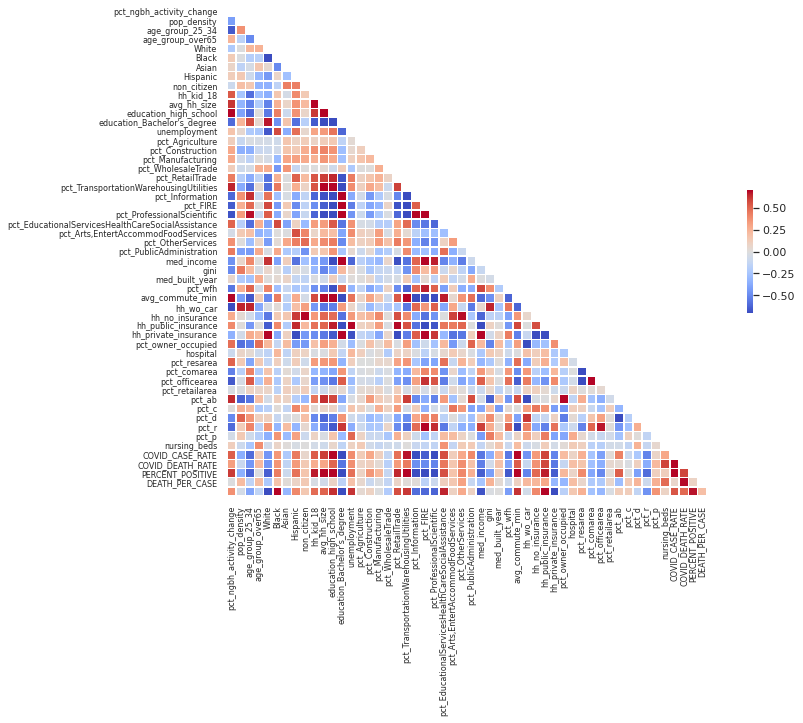

In [14]:
sns.set(style="white")

# Compute the correlation matrix
corr = data.iloc[:,2:].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=0.7, vmin=-0.7, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .25})
plt.yticks(np.arange(52)+0.5, corr.columns.tolist(),fontsize=8)
plt.xticks(np.arange(52)+0.5, corr.columns.tolist(),fontsize=8)

# plt.savefig('../figures/corr_heatmap.pdf', dpi=600,bbox_inches = 'tight')
plt.show()

### 2) Bivariate Modeling
    
        y = Infection rate
        X = Exposure density (neighborhood activity) change

In [15]:
tmp = data[['MODZCTA', 'COVID_CASE_RATE','COVID_DEATH_RATE','PERCENT_POSITIVE','DEATH_PER_CASE', 
            'pct_ngbh_activity_change', 'label']]

In [16]:
# Create log-transformed variables
tmp['COVID_CASE_RATE_log'] = np.log(tmp['COVID_CASE_RATE'])
tmp['COVID_DEATH_RATE_log'] = np.log(tmp['COVID_DEATH_RATE'])
tmp['PERCENT_POSITIVE_log'] = np.log(tmp['PERCENT_POSITIVE'])
tmp['DEATH_PER_CASE_log'] = np.log(tmp['DEATH_PER_CASE'])

# Handle 0 value
tmp['COVID_DEATH_RATE_log'][tmp['COVID_DEATH_RATE']==0] = np.log(1)
tmp['DEATH_PER_CASE_log'][tmp['DEATH_PER_CASE']==0] = np.log(0.01)

# Re-scale a variable
tmp['pct_ngbh_activity_change'] = tmp['pct_ngbh_activity_change']*100

In [17]:
result_1 = sm.ols(formula="COVID_CASE_RATE_log ~ pct_ngbh_activity_change", data=tmp).fit()
result_2 = sm.ols(formula="COVID_DEATH_RATE_log ~ pct_ngbh_activity_change", data=tmp).fit()
result_3 = sm.ols(formula="PERCENT_POSITIVE_log ~ pct_ngbh_activity_change", data=tmp).fit()
result_4 = sm.ols(formula="DEATH_PER_CASE_log ~ pct_ngbh_activity_change", data=tmp).fit()

# Result summary of positivity rate model
result_3.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     PERCENT_POSITIVE_log   R-squared:                       0.415
Model:                              OLS   Adj. R-squared:                  0.412
Method:                   Least Squares   F-statistic:                     124.1
Date:                  Fri, 12 Feb 2021   Prob (F-statistic):           4.02e-22
Time:                          10:39:32   Log-Likelihood:                -18.642
No. Observations:                   177   AIC:                             41.28
Df Residuals:                       175   BIC:                             47.64
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    3.1693      0.027    115.371      0.000       3.115       3.224
pct_ngbh_activity_change     0.0116      0.001     11.138      0.000       0.010       0.014
==============================================================================
Omnibus:                       19.412   Durbin-Watson:                   1.618
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.323
Skew:                          -0.744   Prob(JB):                     8.62e-06
Kurtosis:                       3.975   Cond. No.                         35.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# tmp['label'] = tmp['label'].astype(int)
# colors = ['mediumseagreen', 'yellow', 'tomato',  'steelblue', 'orange']

# plt.figure(figsize=(7,7))
# for i in tmp['label'].unique().tolist():
#     plt.scatter(tmp['pct_ngbh_activity_change'][tmp['label']==i], tmp['PERCENT_POSITIVE_log'][tmp['label']==i],
#                c=colors[i]
#                )

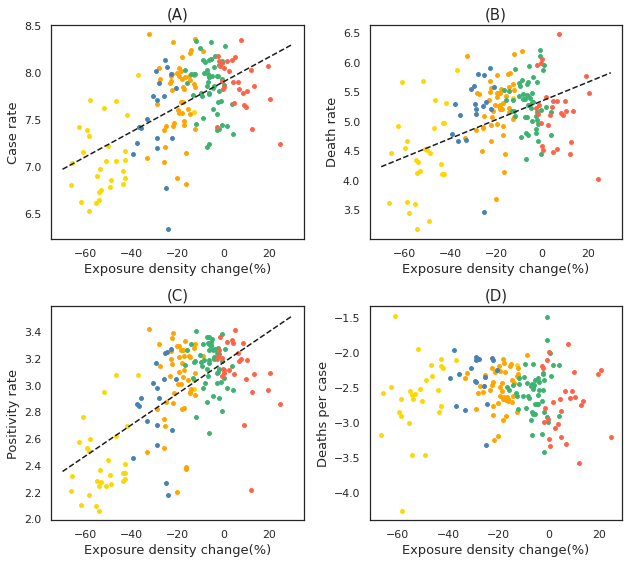

In [23]:
# Create scatter plots with best fitted lines
tmp['label'] = tmp['label'].astype(int)
colors = ['gold', 'orange', 'mediumseagreen', 'steelblue', 'tomato']
cols = ['COVID_CASE_RATE','COVID_DEATH_RATE','PERCENT_POSITIVE','DEATH_PER_CASE']
names = ['Case rate', 'Death rate', 'Positivity rate', 'Deaths per case']
subtitle = ['(A)', '(B)', '(C)', '(D)']
plt.figure(figsize=(9,8))
for c in range(4):
    plt.subplot(2,2,c+1)
    for l in range(5):
        plt.scatter(tmp['pct_ngbh_activity_change'][tmp['label']==l], 
                np.log(tmp[cols[c]][tmp['label']==l]), s=15, color=colors[l])
    
    if c == 0:
        x1 = -70
        x2 = 30
        y1 = 7.897 + 0.013283*(x1)
        y2 = 7.897 + 0.013283*(x2)
        plt.plot([x1, x2], [y1, y2], linestyle='--', color = 'k')
        
    if c == 1:
        x1 = -70
        x2 = 30
        y1 = 5.3415 + 0.015927*(x1)
        y2 = 5.3415 + 0.015927*(x2)
        plt.plot([x1, x2], [y1, y2], linestyle='--', color = 'k')
        
    if c == 2:
        x1 = -70
        x2 = 30
        y1 = 3.1693 + 0.011630*(x1)
        y2 = 3.1693 + 0.011630*(x2)
        plt.plot([x1, x2], [y1, y2], linestyle='--', color = 'k')
    
    plt.xlabel('Exposure density change(%)', fontsize=13)
    plt.ylabel('%s'%(names[c]), fontsize=13) 
    plt.title('%s'%(subtitle[c]), fontsize=15)
plt.tight_layout()
# plt.savefig('../figures/bivariate_revised.pdf', bbox_inches='tight', dpi=600)
plt.show()

### 3) Multivariate modeling

        y = Infection rate
        X = neighborhood activity change + related variables

In [36]:
data.head(2)

,MODZCTA,label,pct_ngbh_activity_change,pop_density,age_group_25_34,age_group_over65,White,Black,Asian,Hispanic,...,pct_c,pct_d,pct_r,pct_p,nursing_beds,COVID_CASE_RATE,COVID_DEATH_RATE,PERCENT_POSITIVE,DEATH_PER_CASE,pct_healthcareworkers
0,11420,1.0,-0.167357,23340.940000,15.39,11.730,15.26,24.51,31.040,24.05,...,6.839860,0.000000,0.186119,0.085304,0.000000,2833.79,202.41,27.99,0.071429,6.29
1,11434,1.0,-0.281592,10078.910015,15.76,10.615,7.78,80.64,1.225,18.41,...,2.174725,32.275527,0.233340,3.952772,0.006145,3133.14,238.39,27.37,0.076087,5.17


In [38]:
# Create log-transformed variables
data['COVID_CASE_RATE_log'] = np.log(data['COVID_CASE_RATE'])
data['COVID_DEATH_RATE_log'] = np.log(data['COVID_DEATH_RATE'])
data['PERCENT_POSITIVE_log'] = np.log(data['PERCENT_POSITIVE'])
data['DEATH_PER_CASE_log'] = np.log(data['DEATH_PER_CASE'])

# Handle zero value
data['COVID_DEATH_RATE_log'][data['COVID_DEATH_RATE']==0] = np.log(1)
data['DEATH_PER_CASE_log'][data['DEATH_PER_CASE']==0] = np.log(0.01)

# Re-scale variable
data['pct_ngbh_activity_change'] = data['pct_ngbh_activity_change']*100

# Create/update additional variables
data['black_hispanic'] = data['Black'] + data['Hispanic']
data['med_income_group'] = pd.qcut(data['med_income'],4, labels=False)
data.rename(columns = {"education_Bachelor's_degree": 'college'}, inplace=True)

In [45]:
# Load clustering results to add label information
cluster = pd.read_csv('../output/features_clustering_result.csv', dtype={'MODZCTA':str})

data = pd.merge(data, cluster[['MODZCTA', 'label']], how='left', on='MODZCTA')

# Create a colume to set cluster group dummy variables
data['label_revised'] = 1
data['label_revised'][data['label_y']==3] = 2
data['label_revised'][data['label_y']==4] = 3
data['label_revised'][data['label_y']==0] = 4
data['label_revised'][data['label_y']==2] = 5

# Convert group variable to dummy variables
data = pd.concat([data, pd.get_dummies(data['label_revised'], prefix='ordinal')], axis=1)
data = pd.concat([data, pd.get_dummies(data['med_income_group'], prefix='income')], axis=1)

,MODZCTA,label
0,11420,0
1,11434,0


In [53]:
# Integrate dummy variables
data['ordinal_d'] = data[['ordinal_1', 'ordinal_2']].sum(axis=1)
data['ordinal_i'] = data[['ordinal_4', 'ordinal_5']].sum(axis=1)

# Interaction terms
data['int_o3_insurance'] = data['ordinal_3']*data['hh_no_insurance']
data['int_o4_insurance'] = data['ordinal_4']*data['hh_no_insurance']
data['int_o5_insurance'] = data['ordinal_5']*data['hh_no_insurance']
data['int_od_insurance'] = data['ordinal_d']*data['hh_no_insurance']

data['int_o3_hw'] = data['ordinal_3']*data['pct_healthcareworkers']
data['int_o4_hw'] = data['ordinal_4']*data['pct_healthcareworkers']
data['int_o5_hw'] = data['ordinal_5']*data['pct_healthcareworkers']

data['int_o3_black'] = data['ordinal_3']*data['Black']
data['int_o5_black'] = data['ordinal_5']*data['Black']
data['int_od_black'] = data['ordinal_d']*data['Black']

data['int_o3_his'] = data['ordinal_3']*data['Hispanic']
data['int_o4_his'] = data['ordinal_4']*data['Hispanic']
data['int_o5_his'] = data['ordinal_5']*data['Hispanic']
data['int_od_his'] = data['ordinal_d']*data['Hispanic']

data['int_o3_bh'] = data['ordinal_3']*data['black_hispanic']
data['int_o4_bh'] = data['ordinal_4']*data['black_hispanic']
data['int_o5_bh'] = data['ordinal_5']*data['black_hispanic']

data['int_o3_65'] = data['ordinal_3']*data['age_group_over65']
data['int_o4_65'] = data['ordinal_4']*data['age_group_over65']
data['int_o5_65'] = data['ordinal_5']*data['age_group_over65']
data['int_od_65'] = data['ordinal_d']*data['age_group_over65']

data['int_o3_p'] = data['ordinal_3']*data['pct_p']
data['int_o4_p'] = data['ordinal_4']*data['pct_p']
data['int_o5_p'] = data['ordinal_5']*data['pct_p']
data['int_od_p'] = data['ordinal_d']*data['pct_p']

data['int_o3_hincome'] = data['ordinal_3']*data['income_3']
data['int_o4_hincome'] = data['ordinal_4']*data['income_3']
data['int_o5_hincome'] = data['ordinal_5']*data['income_3']

data['int_o3_mincome'] = data['ordinal_3']*data['income_2']
data['int_o4_mincome'] = data['ordinal_4']*data['income_2']
data['int_o5_mincome'] = data['ordinal_5']*data['income_2']

data['int_o3_lincome'] = data['ordinal_3']*data['income_0']
data['int_o4_lincome'] = data['ordinal_4']*data['income_0']
data['int_o5_lincome'] = data['ordinal_5']*data['income_0']

data['int_o3_hhkid'] = data['ordinal_3']*data['hh_kid_18']
data['int_o4_hhkid'] = data['ordinal_4']*data['hh_kid_18']
data['int_o5_hhkid'] = data['ordinal_5']*data['hh_kid_18']
data['int_od_hhkid'] = data['ordinal_d']*data['hh_kid_18']

data['int_o3_income'] = data['ordinal_3']*data['med_income_group']
data['int_o5_income'] = data['ordinal_5']*data['med_income_group']
data['int_od_income'] = data['ordinal_4']*data['med_income_group']

data['int_o3_owner'] = data['ordinal_3']*data['pct_owner_occupied']
data['int_o5_owner'] = data['ordinal_5']*data['pct_owner_occupied']
data['int_od_owner'] = data['ordinal_4']*data['pct_owner_occupied']

data['int_o3_wfh'] = data['ordinal_3']*data['pct_wfh']
data['int_o5_wfh'] = data['ordinal_5']*data['pct_wfh']
data['int_od_wfh'] = data['ordinal_4']*data['pct_wfh']

In [56]:
# Final multivariate model (positivity rate model)
result_m = sm.ols(formula="PERCENT_POSITIVE_log ~ \
 + ordinal_d + ordinal_3 + ordinal_5 \
 + Black \
 + Hispanic \
 + pct_owner_occupied \
 + hh_kid_18 \
 + pct_wfh \
 + nursing_beds \
 + hh_no_insurance + int_od_insurance + int_o3_insurance + int_o5_insurance \
 + age_group_over65  \
 + pct_p \
 ", data=data).fit()
result_m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     PERCENT_POSITIVE_log   R-squared:                       0.832
Model:                              OLS   Adj. R-squared:                  0.817
Method:                   Least Squares   F-statistic:                     53.26
Date:                  Wed, 03 Feb 2021   Prob (F-statistic):           2.04e-54
Time:                          14:19:22   Log-Likelihood:                 91.949
No. Observations:                   177   AIC:                            -151.9
Df Residuals:                       161   BIC:                            -101.1
Df Model:                            15                                         
Covariance Type:              nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.3592      0.116     20.410      0.000       2.131       2.587
ordinal_d             -0.4432      0.091     -4.860      0.000      -0.623      -0.263
ordinal_3             -0.2281      0.096     -2.378      0.019      -0.418      -0.039
ordinal_5             -0.1295      0.078     -1.658      0.099      -0.284       0.025
Black                  0.0042      0.001      7.292      0.000       0.003       0.005
Hispanic               0.0054      0.001      5.389      0.000       0.003       0.007
pct_owner_occupied     0.0025      0.001      2.755      0.007       0.001       0.004
hh_kid_18              0.0126      0.002      5.577      0.000       0.008       0.017
pct_wfh               -0.0160      0.005     -3.004      0.003      -0.026      -0.005
nursing_beds           0.7715      0.699      1.104      0.271      -0.609       2.152
hh_no_insurance       -0.0025      0.007     -0.347      0.729      -0.017       0.012
int_od_insurance       0.0457      0.012      3.920      0.000       0.023       0.069
int_o3_insurance       0.0214      0.010      2.233      0.027       0.002       0.040
int_o5_insurance       0.0175      0.009      1.989      0.048       0.000       0.035
age_group_over65       0.0077      0.003      2.502      0.013       0.002       0.014
pct_p                 -0.0020      0.002     -1.098      0.274      -0.006       0.002
==============================================================================
Omnibus:                       35.393   Durbin-Watson:                   2.258
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              105.215
Skew:                          -0.773   Prob(JB):                     1.42e-23
Kurtosis:                       6.446   Cond. No.                     3.76e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.76e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""